In [10]:
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import csv
import node2vec
import itertools

# Creating the co-occurrence graph

In [117]:
G = nx.Graph()
with open('../data/ccp_adjacency_list.csv', newline='') as all_names:
    name_reader = csv.reader(all_names, delimiter=',')
    next(name_reader)
    for row in name_reader:
        for ppl_name in row[1:]:
            if not G.has_node(ppl_name):
                G.add_node(ppl_name)
                
        # each edge can include co-occurrences that exist in other documents
        for p1, p2 in itertools.combinations(row[1:], 2):
            if G.has_edge(p1, p2):
                G.edges[p1, p2]['weight'] += 1
                G.edges[p1, p2]['documents'].append(row[0])
            else:
                G.add_edge(p1, p2, weight=1, documents=[row[0]])
                G.add_edge(p1, p2, weight=1)

nx.write_gml(G, '../data/co_occurrence_graph.gml')

# Clustering with Girvan Newman

In [1]:
from igraph import *
# either import or make your own like the one above
co_graph = Graph.Read_GML('../data/co_occurrence_graph.gml')

In [ ]:
# Girvan Newman clusters
gn_clusters = co_graph.community_edge_betweenness().as_clustering()

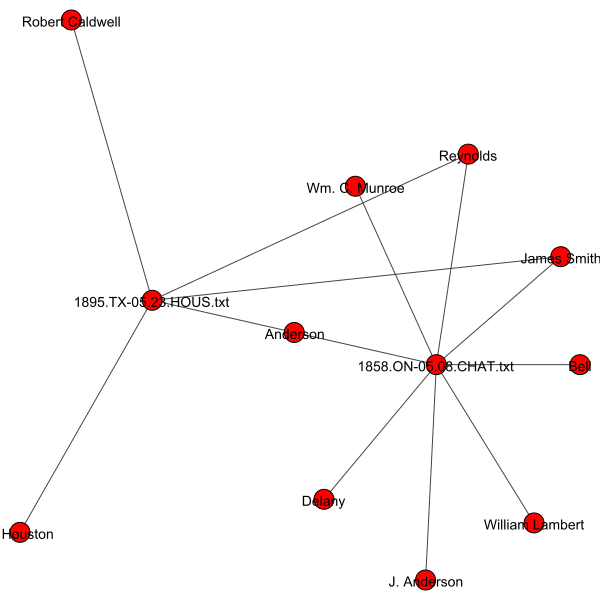

In [57]:
subgraph = gn_clusters.subgraph(0)
layout = subgraph.layout("rt_circular")
plot(subgraph, layout=layout)

In [ ]:
writer = csv.writer(open("../data/gn_clusters_co.csv", "w", newline=''))
writer.writerow(["cluster", "members"])
count = 0
for cluster in gn_clusters:
    members = [co_graph.vs[member]["label"] for member in cluster]
    writer.writerow([count] + members)
    count += 1

## Producing the JSON file for D3.js

In [16]:
import json
nodes = []
links = []
count = 0
for cluster in gn_clusters:
    nodes += [{"id" : co_graph.vs[member]['label'], "group": count} for member in cluster]
    count += 1

for e in co_graph.es:
    links += [{"source": co_graph.vs[e.source]['label'], "target": co_graph.vs[e.target]['label']}]

with open('../visualizations/gn_clusters_co.json', 'w') as gn_cluster_json:
    json.dump({"nodes": nodes, "links": links}, gn_cluster_json)

# Clustering with Louvain

In [3]:
# Louvain clusters
louvain_clusters = co_graph.community_multilevel()

['Lawrence Chaplin']


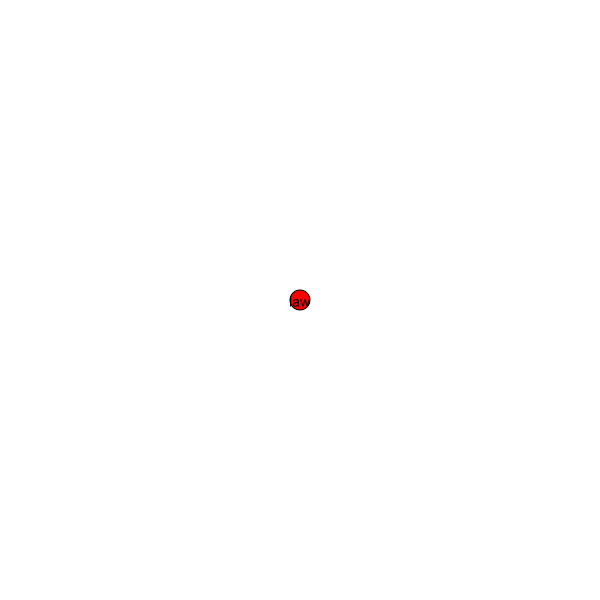

In [76]:
subgraph_l = louvain_clusters.subgraph(3)
print(subgraph_l.vs["label"])
layout_l = subgraph_l.layout_auto()
plot(subgraph_l, layout=layout_l, vertex_label=['law'])

In [38]:
with open("../data/louvain_clusters_co.csv", "w", newline='') as louvain_writer:
    writer = csv.writer(louvain_writer)
    writer.writerow(["cluster", "members"])
    cluster_id = 0
    for subgraph in louvain_clusters.subgraphs():
        writer.writerow([cluster_id] + subgraph.vs["label"])
        cluster_id += 1

## Producing the JSON file for D3.js

In [40]:
import json

with open('../data/louvain_clusters_co.json', 'w') as louvain_cluster_json:
    nodes = []
    links = []
    count = 0
    for cluster in louvain_clusters:
        nodes += [{"id" : co_graph.vs[member]['label'], "group": count} for member in cluster]
        count += 1

    for e in co_graph.es:
        links += [{"source": co_graph.vs[e.source]['label'], "target": co_graph.vs[e.target]['label']}]
    
    json.dump({"nodes": nodes, "links": links}, louvain_cluster_json)

# Clustering with Node2Vec

In [ ]:
# Precompute probabilities and generate walks
node2vec = node2vec.Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Embed
model = node2vec.fit(window=10, min_count=1, batch_words=4)
# try min_count = 100 and min_count = 500

# Any keywords acceptable by gensim.Word2Vec can be passed,
# `diemnsions` and `workers` are automatically passed (from the Node2Vec constructor)

# Look for most similar nodes
print(model.wv.most_similar('Cornish'))  # Output node names are always strings

# Save embeddings for later use
model.wv.save_word2vec_format('../data/co_graph.emb')

# Save model for later use
model.save('../data/co_graph.model')

## Loading the word2vec/node2vec model

In [5]:
from gensim.models import word2vec

model = word2vec.Word2Vec.load('../data/co_graph.model')
X = model.wv[model.wv.vocab]
model.wv.most_similar('Cornish') #same man connected to Ontario and Texas

C:\Users\arshi\AppData\Roaming\Python\Python37\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\arshi\AppData\Roaming\Python\Python37\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Charles W. Gardiner', 0.9428948760032654),
 ('Van Brackle', 0.9361433982849121),
 ('Bacon', 0.9356737732887268),
 ('Abraham D. Shadd', 0.9347283840179443),
 ('G. Barbadoes', 0.9312083721160889),
 ('Hughes', 0.9281817674636841),
 ('Anthony Campbell', 0.9256470203399658),
 ('Joshua P.B. Eddy', 0.9234169721603394),
 ('Orange', 0.9134079217910767),
 ('Geo', 0.9090765118598938)]

##  Visualizing the node2vec model with TSNE
[Reference here](https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne)

In [12]:
labels = []
tokens = []

for word in model.wv.vocab:
    tokens.append(model.wv[word])
    labels.append(word)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 

for i in range(len(x)):
    plt.scatter(x[i],y[i])
plt.show()

## Producing the csv file for d3.js

In [8]:
# TSNE x,y coords in a csv
with open('../data/node2vec_viz_coordinates.csv', 'w', newline='') as node2vecviz:
    writer = csv.writer(node2vecviz)
    writer.writerow(["Name", "x", "y"])
    for label, xc, yc in zip(labels, x, y):
        writer.writerow([label, xc, yc])